# Table of content # 


1. [  Description ](#desc)

2. [ The Math behind  ](#math)

3. [  from scratch ](#code)
    1. [ Import Library ](#import)    
    2. [ Class PCA ](#class)
    3. [ Work with Iris data ](#dataset)

(f): function
(v): variable
(s): special words
convjs_net:
    * (f)make_layer: takes a list of layer definitions and creates the network layer objects
    * (s) fc: fully-connected
    
 

In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
import time

################## plotting #######################
%matplotlib inline
# %load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

## Toy data

In [61]:
def onehot(targets):
    if isinstance(targets, tuple):
        targets = np.ravel(targets)
    z = list(set(targets))
    size = len(z)
    return [ [int(target == z[i]) for i in range(size)] for target in targets]

def get_sep_linear_data():
    mean1 = [0, 10]
    mean2 = [10, 0]
    mean3 = [10, -10]
    cov = [[10,0.8],[0.8, 0.6]]

    X1 = np.random.multivariate_normal(mean1, cov, 100)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 100)
    y2 = np.zeros(len(X2)) 
    X3 = np.random.multivariate_normal(mean3, cov, 100)
    y3 = np.ones(len(X3)) * -1
    return X1, y1, X2, y2, X3, y3
def get_sep_non_linear_data():
    mean1 = [-1, 2]
    mean2 = [1, -1]
    mean3 = [4, -4]
    mean4 = [-4, 4]
    cov = [[1.0,0.8], [0.8, 1.0]]
    X1 = np.random.multivariate_normal(mean1, cov, 50)
    print(X1.shape)
    X1 = np.vstack((X1, np.random.multivariate_normal(mean3, cov, 50)))
    print(X1.shape)
    y1 = np.ones(len(X1))
    X2 = np.random.multivariate_normal(mean2, cov, 50)
    X2 = np.vstack((X2, np.random.multivariate_normal(mean4, cov, 50)))
    y2 = np.ones(len(X2)) * -1
    return X1, y1, X2, y2

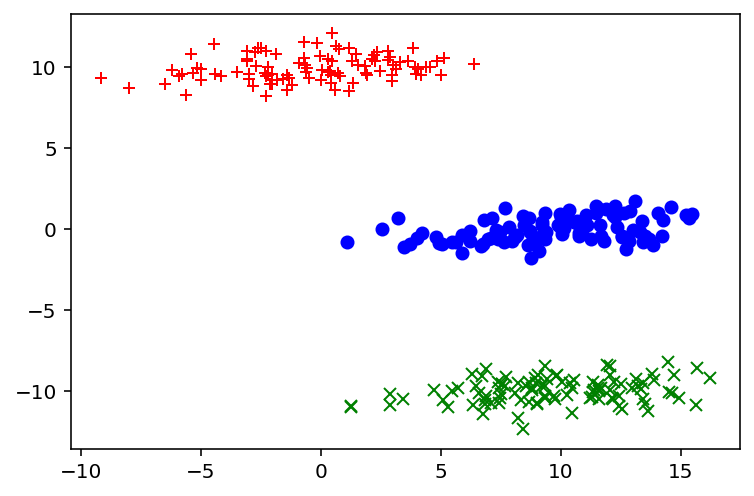

In [69]:
X1, y1, X2, y2, X3, y3 = get_sep_linear_data()
plt.plot(X1[:, 0], X1[:, 1], 'r+')
plt.plot(X2[:, 0], X2[:, 1], 'bo')
plt.plot(X3[:, 0], X3[:, 1], 'gx')

X = np.vstack((X1, X2, X3))
y = onehot((y1, y2, y3))

In [71]:
X[0], y[0]

(array([-2.30501323,  9.62072864]), [0, 1, 0])

## Neural net model

In [50]:
class NN:
    def __init__(self, sizes, epochs = 10, lr = .001):
        self.sizes = sizes
        self.epochs =  epochs
        self.lr = lr

        self.params = self.init_params()
    
    def init_params(self):
        in_layer = self.sizes[0]
        h1 = self.sizes[1]
        h2 = self.sizes[2]
        out_layer = self.sizes[3]
        
        # The weight is not transposed in advance for the convenience, i.e y = XW1 (n x d x d x h1)  
        # Assume no bias
        
        params = {
            'W1': np.random.randn(in_layer, h1) * np.sqrt(1/h1),
            'W2': np.random.randn(h1, h2) * np.sqrt(1/h2),
            'W3': np.random.randn(h2, out_layer) * np.sqrt(1/out_layer),
        }
        
        return params

    def relu(self, x, derivative = False):
        if derivative:
            if x > 0: return 1 
            else: return 0
        return np.max(x, 0)
    
    def sigmoid(self, x, derivative = False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))
    
    def softmax(self, x):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        # *Can optimize use log before softmax => LSE
        return exps / np.sum(exps, axis=0)
    
    def forward(self, X):
        """
        Args: 
            X_train: Input (n x in_layer)
        Return:
            Output of NN: Y = NN(X) (n x out_layer)
        """
        params = self.params 
        
        params['X']  = X
        params['O1'] = np.dot(params['X'], params['W1']) # (n x i x i x h1)
        params['Z1'] = self.sigmoid(params['O1'])
#         print('params[Z1] ', params['Z1'].shape)
        params['O2'] = np.dot(params['Z1'], params['W2']) # (n x h1 x h1 x h2)
        params['Z2'] = self.sigmoid(params['O2'])
#         print('params[Z2] ', params['Z2'].shape)
        params['O3'] = np.dot(params['Z2'], params['W3']) # (n x h2 x h2 x o)
        params['Y'] = self.softmax(params['O3'])
#         print('params[Y] ', params['Y'].shape)
        self.params = {}
        self.params = params
        
        return params['Y']
    
    def fit(self, X,y):
        
        self.X_train = X
        self.y_train = y
        self.update()
    
    def gradident(self):

        """ 
        L = - Sum_i(y_i*log(y_i))
        dL/dW = softmax(o) - y
        """
        self.forward(self.X_train)
        params = self.params

        """
        y_train: (n x out_layer)
        """
        grad = {}
        # Y = softmax(O3)
        # dL/dO3 = softmax(O3) - y_train
#         grad['O3'] = params['Y'] - self.y_train # (n x out_layer)
        error = params['Y'] - self.y_train # (n x out_layer)
#         print('grad[O3] ', grad['O3'].shape)

        # O3 = W3 * Z2
        # dL/dW3 = dL/dO3 x dO3/dW3 =dL/dO3 x Z2
    
#         print('params[Z2] ', params['Z2'].shape)
        grad['W3'] = params['Z2'].T.dot(error) # (out_layer x n x n x h2)

        
#         print('grad[W3] ', grad['W3'].shape)
        
        # Z2 = Relu(O2)
        # O2 = W2 * Z1
        # dL/dW2 = dL/dO3 x dO3/dZ2 x dZ2/dO2 x dO2/dW2 = dL/dO3 x W3 x Relu'(O2) x Z1
        
#         print("grad['O3'].dot(params['W3'].T)", grad['O3'].dot(params['W3'].T).shape)
#         print("self.sigmoid(params['O2'], derivative = True).T", self.sigmoid(params['O2'], derivative = True).shape)
#         print("params['Z1']", params['Z1'].shape)
        grad['W2'] =params['Z1'].T.dot(error.dot(params['W3'].T) \
                    * self.sigmoid(params['O2'], derivative = True))
        # (out_layer x n).T x (out_layer x h2) x (h2 x n) x (n x h1))
#         print('grad[W2] ', grad['W2'].shape)
        
        # Z1 = Relu(O1)
        # O1 = W1 * I
        # dL/dW1 = dL/dO3 x dO3/dZ2 x dZ2/dO2 x dO2/dZ1 x dZ1/dO1 x dO1/dW1 
        #        = dL/dO3 x  W3 x  Relu'(O2) x W2 x Relu'(O1) x I
#         print("grad['O3'].dot(params['W3'].T) * self.sigmoid(params['O2'], derivative = True)", (grad['O3'].dot(params['W3'].T) * self.sigmoid(params['O2'], derivative = True)).shape)
#         print("self.relu(params['O1'], derivative = True)", self.sigmoid(params['O1'], derivative = True).shape)
#         print("params['W2']",params['W2'].shape)
#         print("params['X']", params['X'].shape)
#         print("grad['O3'].dot(params['W3'].T)* self.sigmoid(params['O2'], derivative = True)", (grad['O3'].dot(params['W3'].T)
#                                        * self.sigmoid(params['O2'], derivative = True)).dot(params['W2'].T).shape
#                                        )

        grad['W1'] = params['X'].T.dot((error.dot(params['W3'].T)
                                       * self.sigmoid(params['O2'], derivative = True))
                                       .dot(params['W2'].T) 
                                       * self.sigmoid(params['O1'], derivative = True))
    
#         print('grad[W1] ', grad['W1'].shape)
        
        self.grad = grad
    
    def sgd(self, w):
        
        self.params[w] =self.params[w] - self.lr * self.grad[w]
        
    def update(self):
        for epoch in range(self.epochs):
#             self.forward()
#             print("grad", self.grad)
#             print("params", self.params)
#             print(self.params)
#             print(self.grad)
            self.gradident() # calculate gradient of weights
            for w in ['W1', 'W2', 'W3']:
                self.sgd(w) # update weights

    def cross_entropy():
        pass
    
    def predict(self, X):
        return self.forward(X)
        
    
    
        
        

    

In [65]:
mlp = NN([4,5,6,3], epochs=1000)
X = np.array([[1,2,3,1], [5,6,4,1]])
y = np.array([[1,0,0],[0,1,0]])
mlp.fit(X,y)
mlp.predict([1,2,3,1])

array([0.06706951, 0.9005943 , 0.03233619])

In [49]:
x

params[Z1]  (2, 4)
params[Z2]  (2, 5)
params[Y]  (2, 2)


(2, 2)

## Refs

IBM tutorial

https://developer.ibm.com/articles/neural-networks-from-scratch/

Theory
https://doug919.github.io/notes-on-backpropagation-with-cross-entropy/#mjx-eqn-eqz